In [1]:
library(tidyverse)
library(glue)
library(here)
suppressPackageStartupMessages({library(rtracklayer); library(GenomicRanges)})

devtools::load_all(".")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.0
✔ tibble  2.1.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

here() starts at /mnt/expressions/mp/ychr
Warning message:
“no function found corresponding to methods exports from ‘GenomicRanges’ for: ‘concatenateObjects’”Loading ychr


# Calculate coverage for all three sets of capture regions

In [2]:
cov_df <-
    list.files(here("data/bam"), ".*.bam$", full.names = TRUE) %>%
    str_subset("control", negate = TRUE) %>%
    map_dfr(function(bam) {
        name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "")
        regions <- basename(bam) %>% str_replace_all("^([a-z]+)_.*", "\\1")
        bed <- here(glue("data/coord/capture_{regions}.bed"))
        coverage_df <-
            get_coverage(bed, bam) %>%
            as.data.frame %>%
            mutate(name = name, regions = regions) %>%
            rename(chrom = seqnames) %>%
            select(-width, -strand, -pos)
    }) %>%
    mutate(set = case_when(
        name %in% c("spy1", "mez2", "elsidron1", "elsidron2", "den8", "den4") ~ "capture",
        name %in% c("ustishim", "shotgun_spy1", "shotgun_mez2", "shotgun_den8") ~ "shotgun_ancient",
        TRUE ~ "shotgun_modern"
    ))

In [3]:
factors <- c(
    filter(cov_df, set == "capture")$name %>% unique,
    filter(cov_df, set == "shotgun_ancient")$name %>% unique,
    filter(cov_df, set == "shotgun_modern")$name %>% unique
)

In [4]:
saveRDS(cov_df, here("data/rds/cov_df.rds"))

In [5]:
cov_df %>%
group_by(name, regions) %>%
summarise(avg_coverage = mean(coverage)) %>%
spread(regions, avg_coverage) %>%
.[match(factors, .$name), ]

name,exome,full,lippold
den4,1.0760348,1.6634329,1.8752074
den8,2.0513726,3.6038601,3.9959893
elsidron1,3.3353000,NA,NA
mez2,8.6018223,14.6456430,16.4195905
spy1,0.4578273,0.9103632,0.9075269
elsidron2,NA,NA,8.2304268
ustishim,15.3041056,20.3913371,19.8770105
shotgun_mez2,NA,0.8879353,NA
shotgun_spy1,NA,0.5218778,NA
a00,21.5008471,21.2707718,21.6891376


In [6]:
control_cov_df <-
    list.files(here("data/bam"), ".*.bam$", full.names = TRUE) %>%
    str_subset("control") %>%
    map_dfr(function(bam) {
        map_dfr(c("exome", "lippold", "full"), function(regions) {
            name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "")
            bed <- here(glue("data/coord/capture_{regions}.bed"))
            coverage_df <-
                get_coverage(bed, bam) %>%
                as.data.frame %>%
                mutate(name = name, regions = regions) %>%
                rename(chrom = seqnames) %>%
                select(-width, -strand, -pos)
        })
    })

In [7]:
control_cov_df %>%
group_by(name, regions) %>%
summarise(avg_coverage = mean(coverage)) %>%
spread(regions, avg_coverage)

name,exome,full,lippold
stuttgart,0.03195300,0.02831108,0.06171226
vindija,0.05848638,0.06643895,0.12580111


Inflated zeroes due to differences in filtering between BAM files and capture sets (ancient DNA BAM files filtered more strictly).

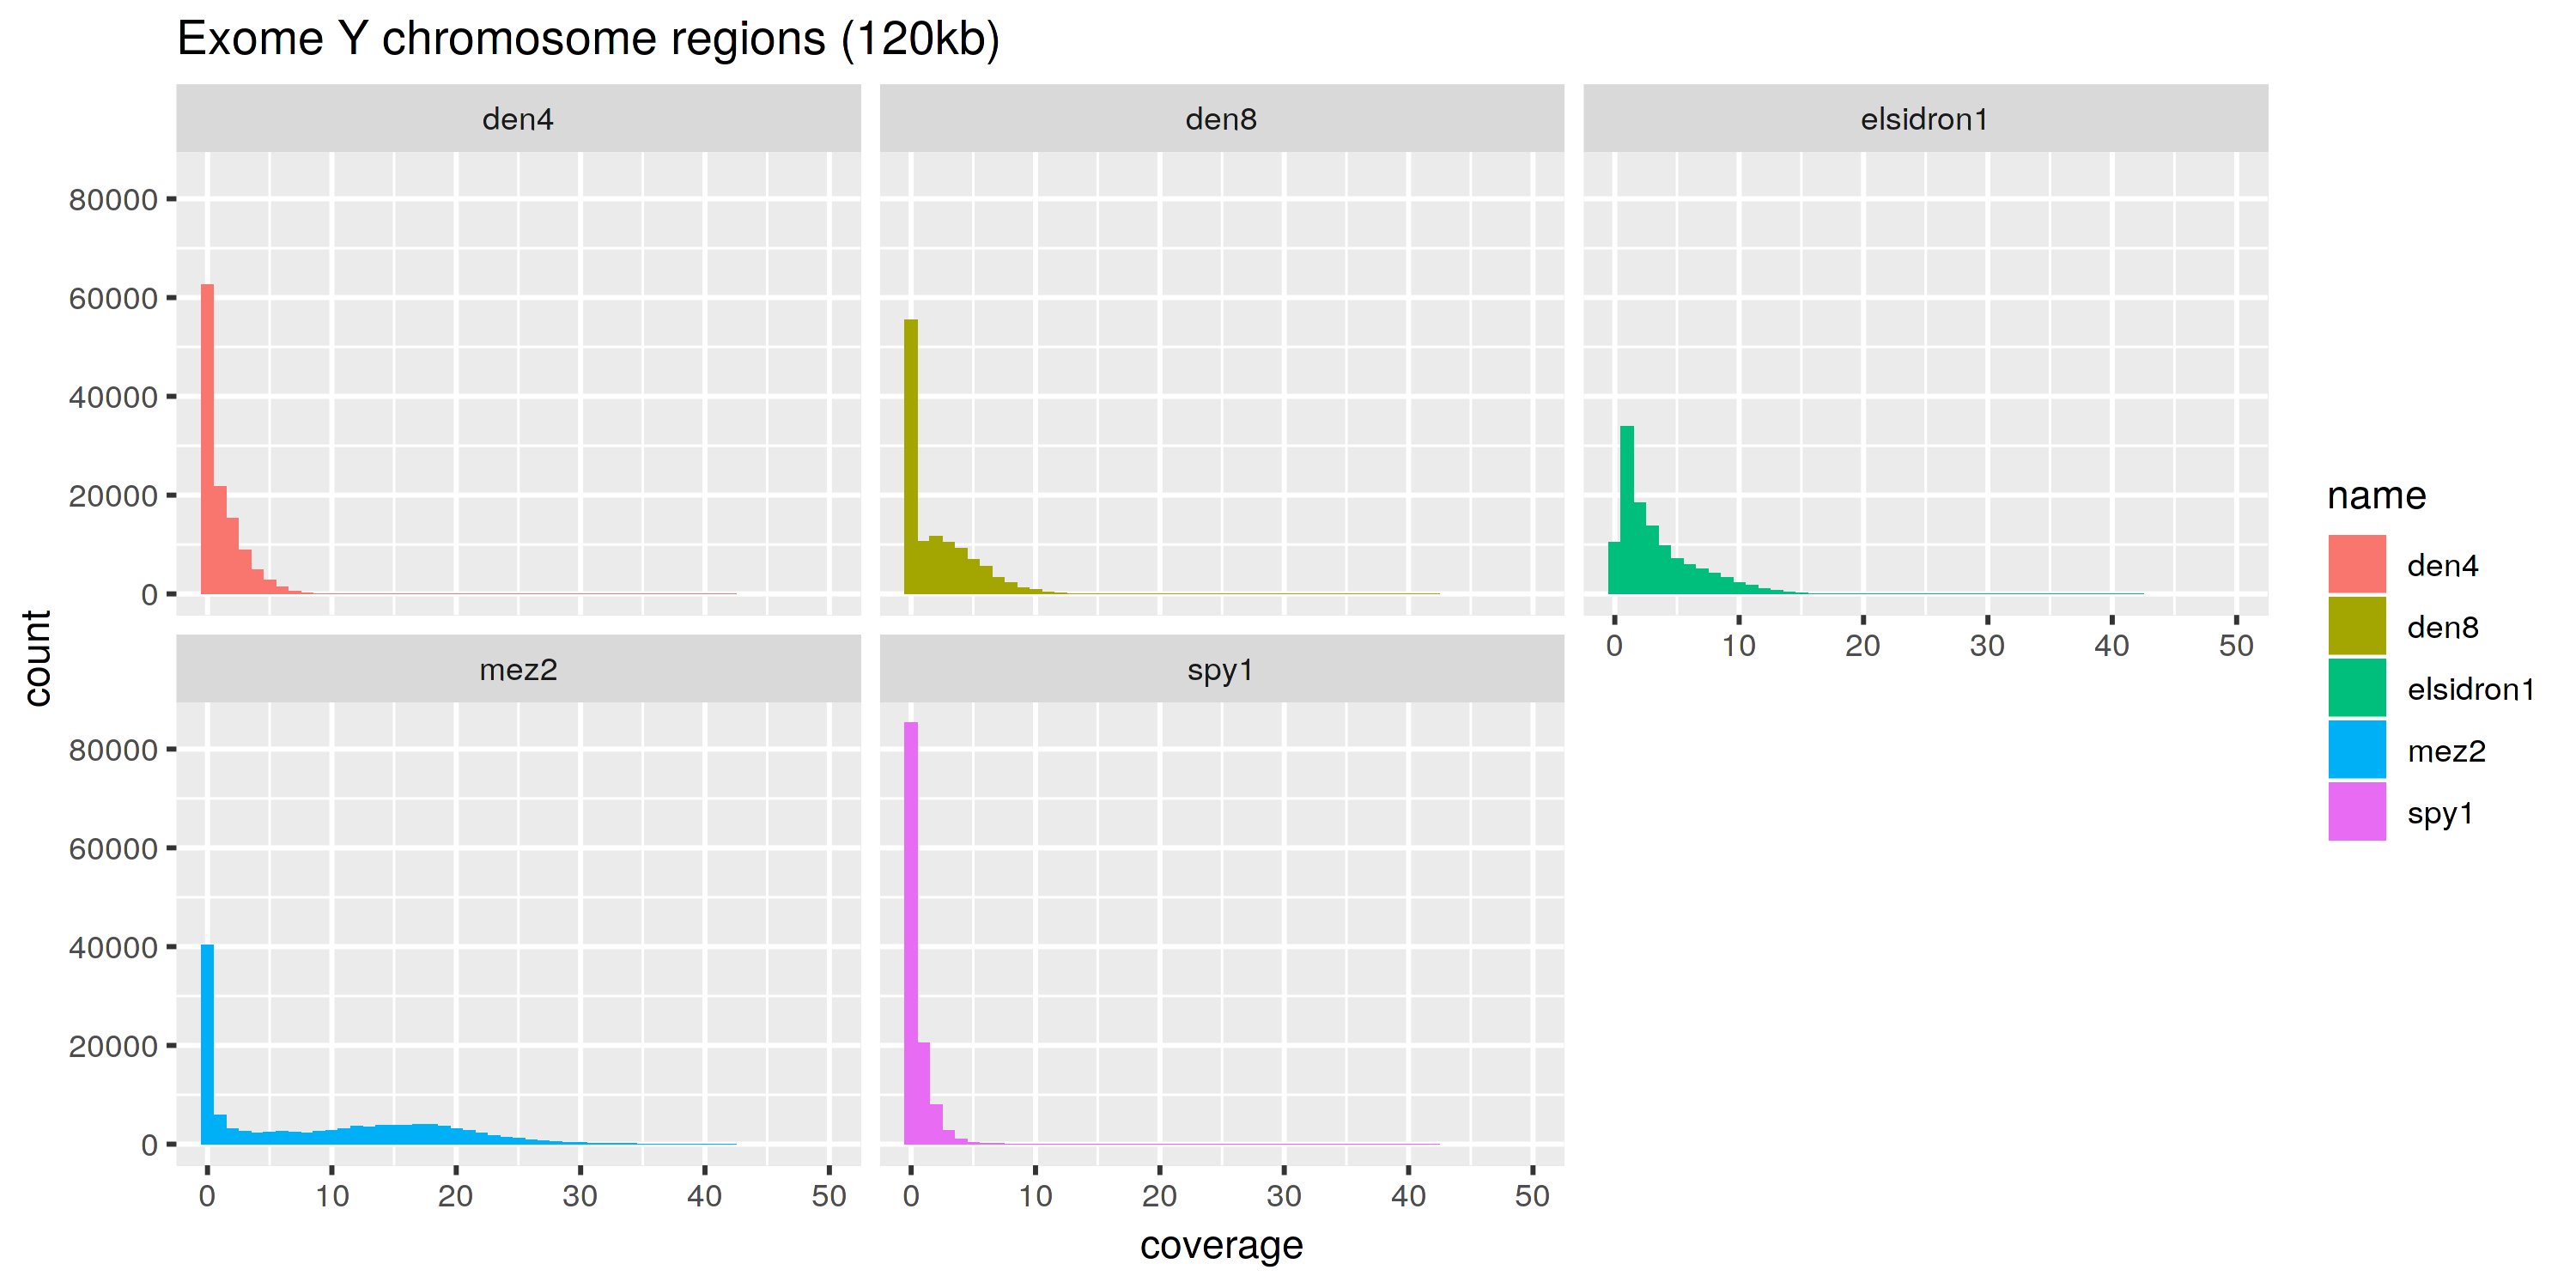

In [8]:
set_dim(10, 5, 300)

cov_df %>%
filter(regions == "exome") %>%
filter(set == "capture", !name %in% c("den", "neand")) %>%
mutate(name = factor(name, levels = factors)) %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    facet_wrap(~ name) +
    coord_cartesian(x = c(0, 50)) +
    ggtitle("Exome Y chromosome regions (120kb)")

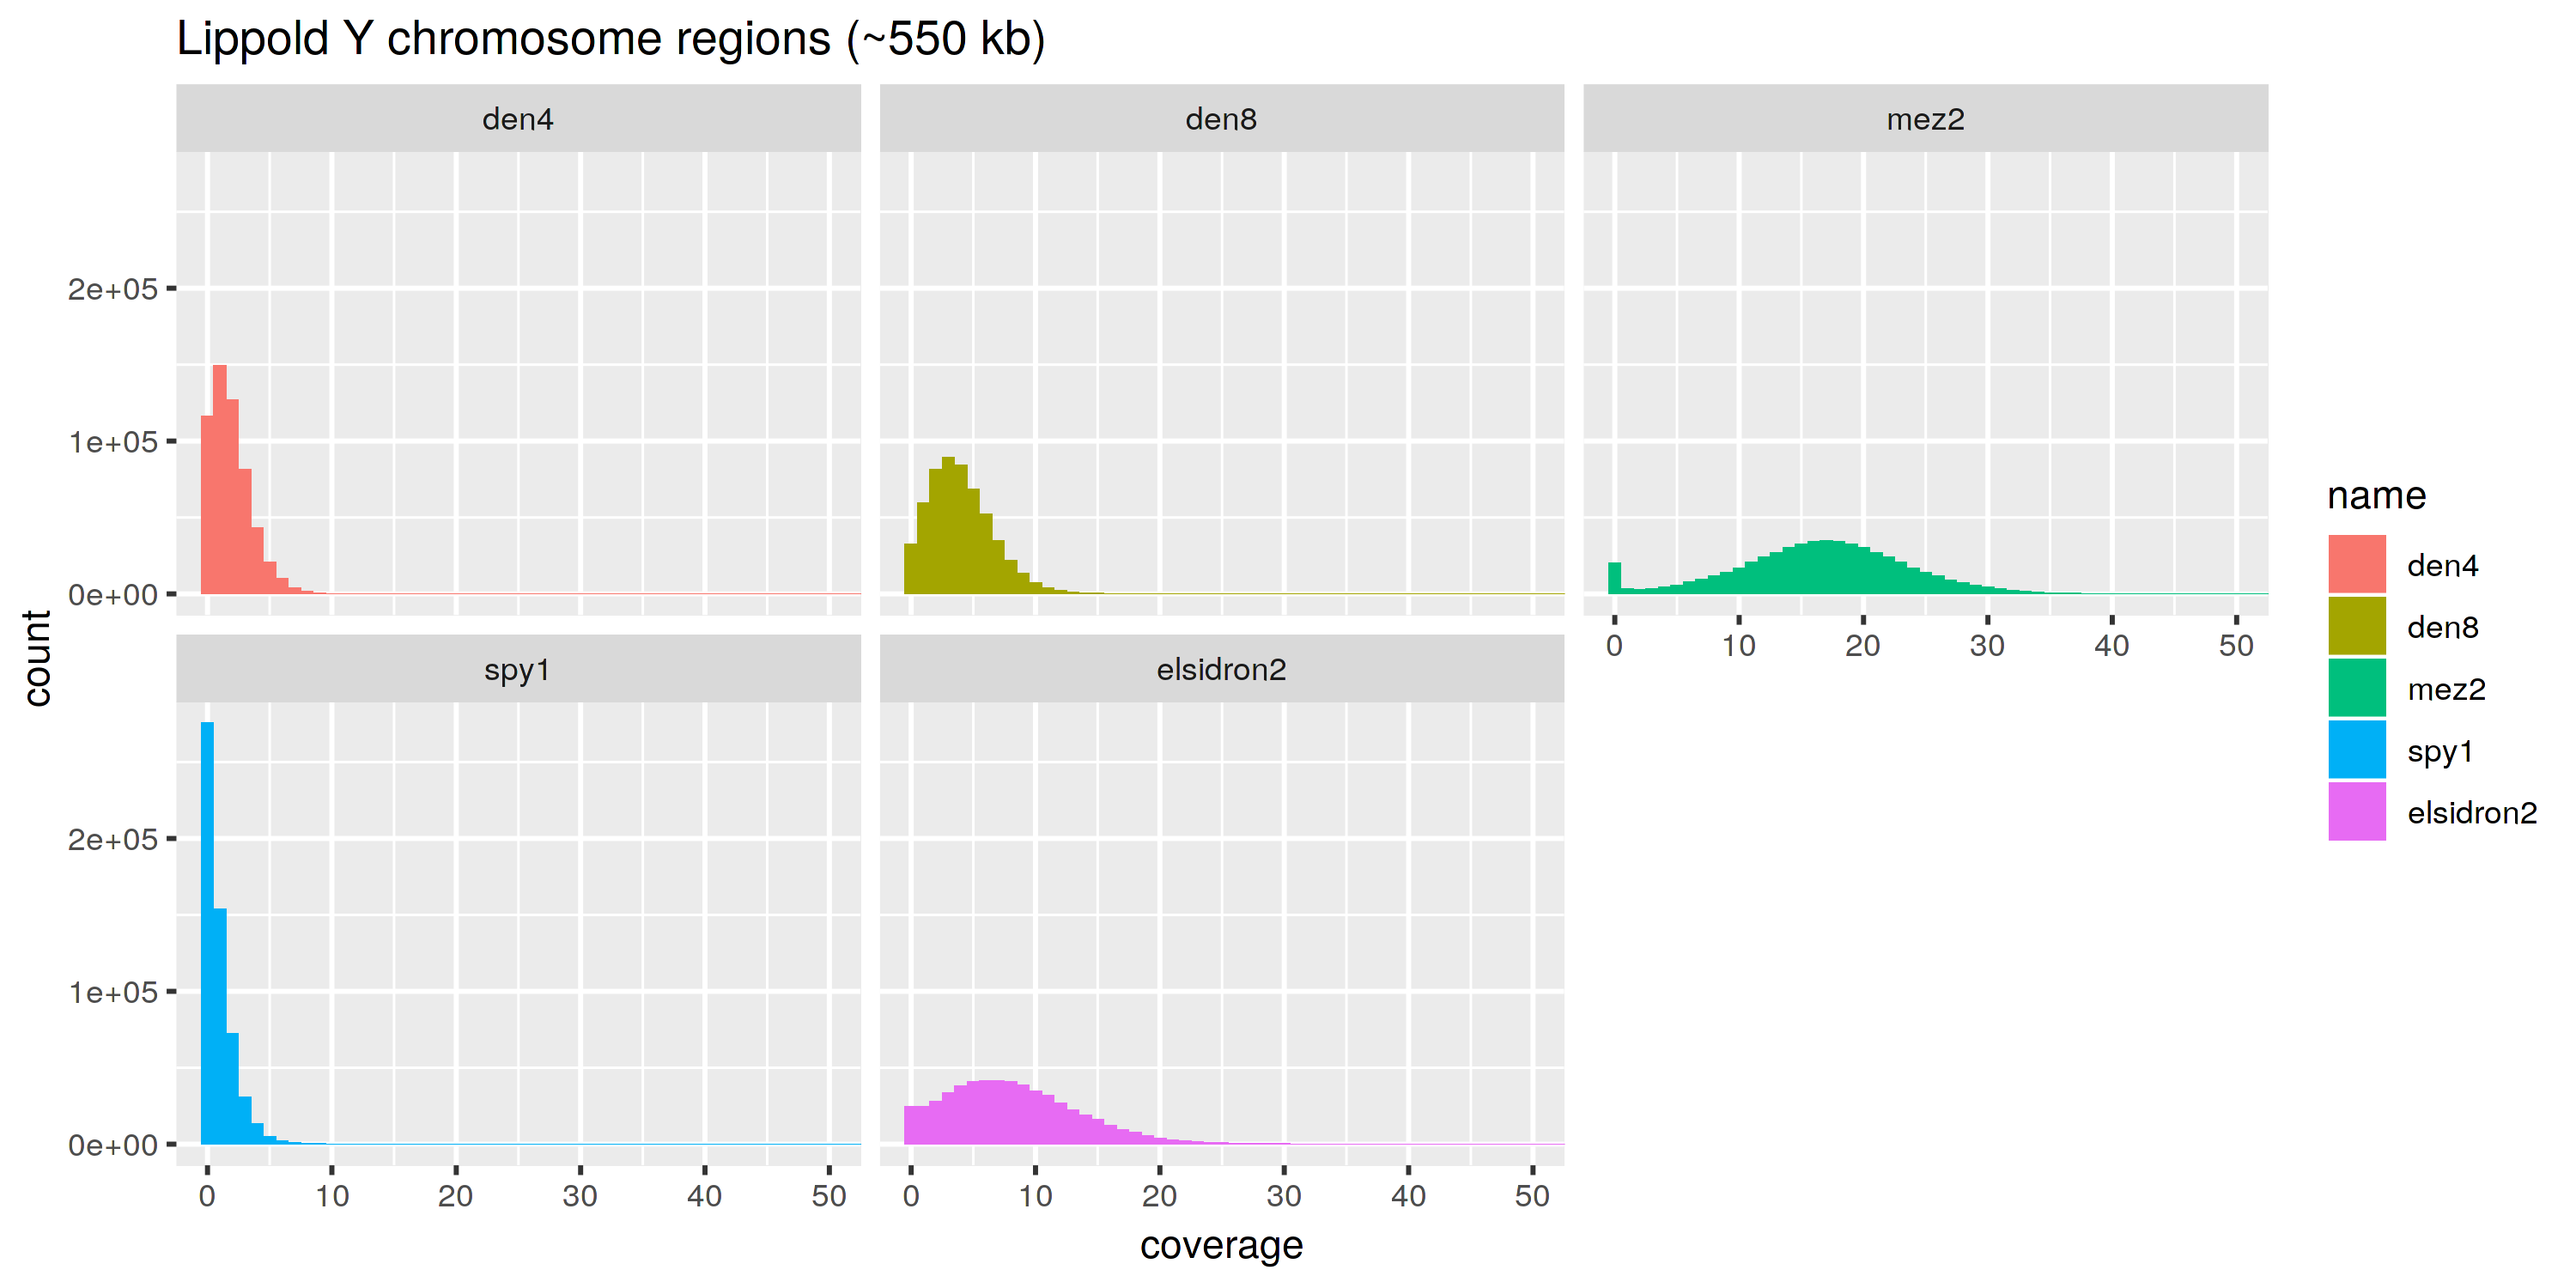

In [9]:
set_dim(10, 5, 300)

cov_df %>%
filter(regions == "lippold") %>%
filter(set == "capture", !name %in% c("den", "neand")) %>%
mutate(name = factor(name, levels = factors)) %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    facet_wrap(~ name) +
    coord_cartesian(x = c(0, 50)) +
    ggtitle("Lippold Y chromosome regions (~550 kb)")

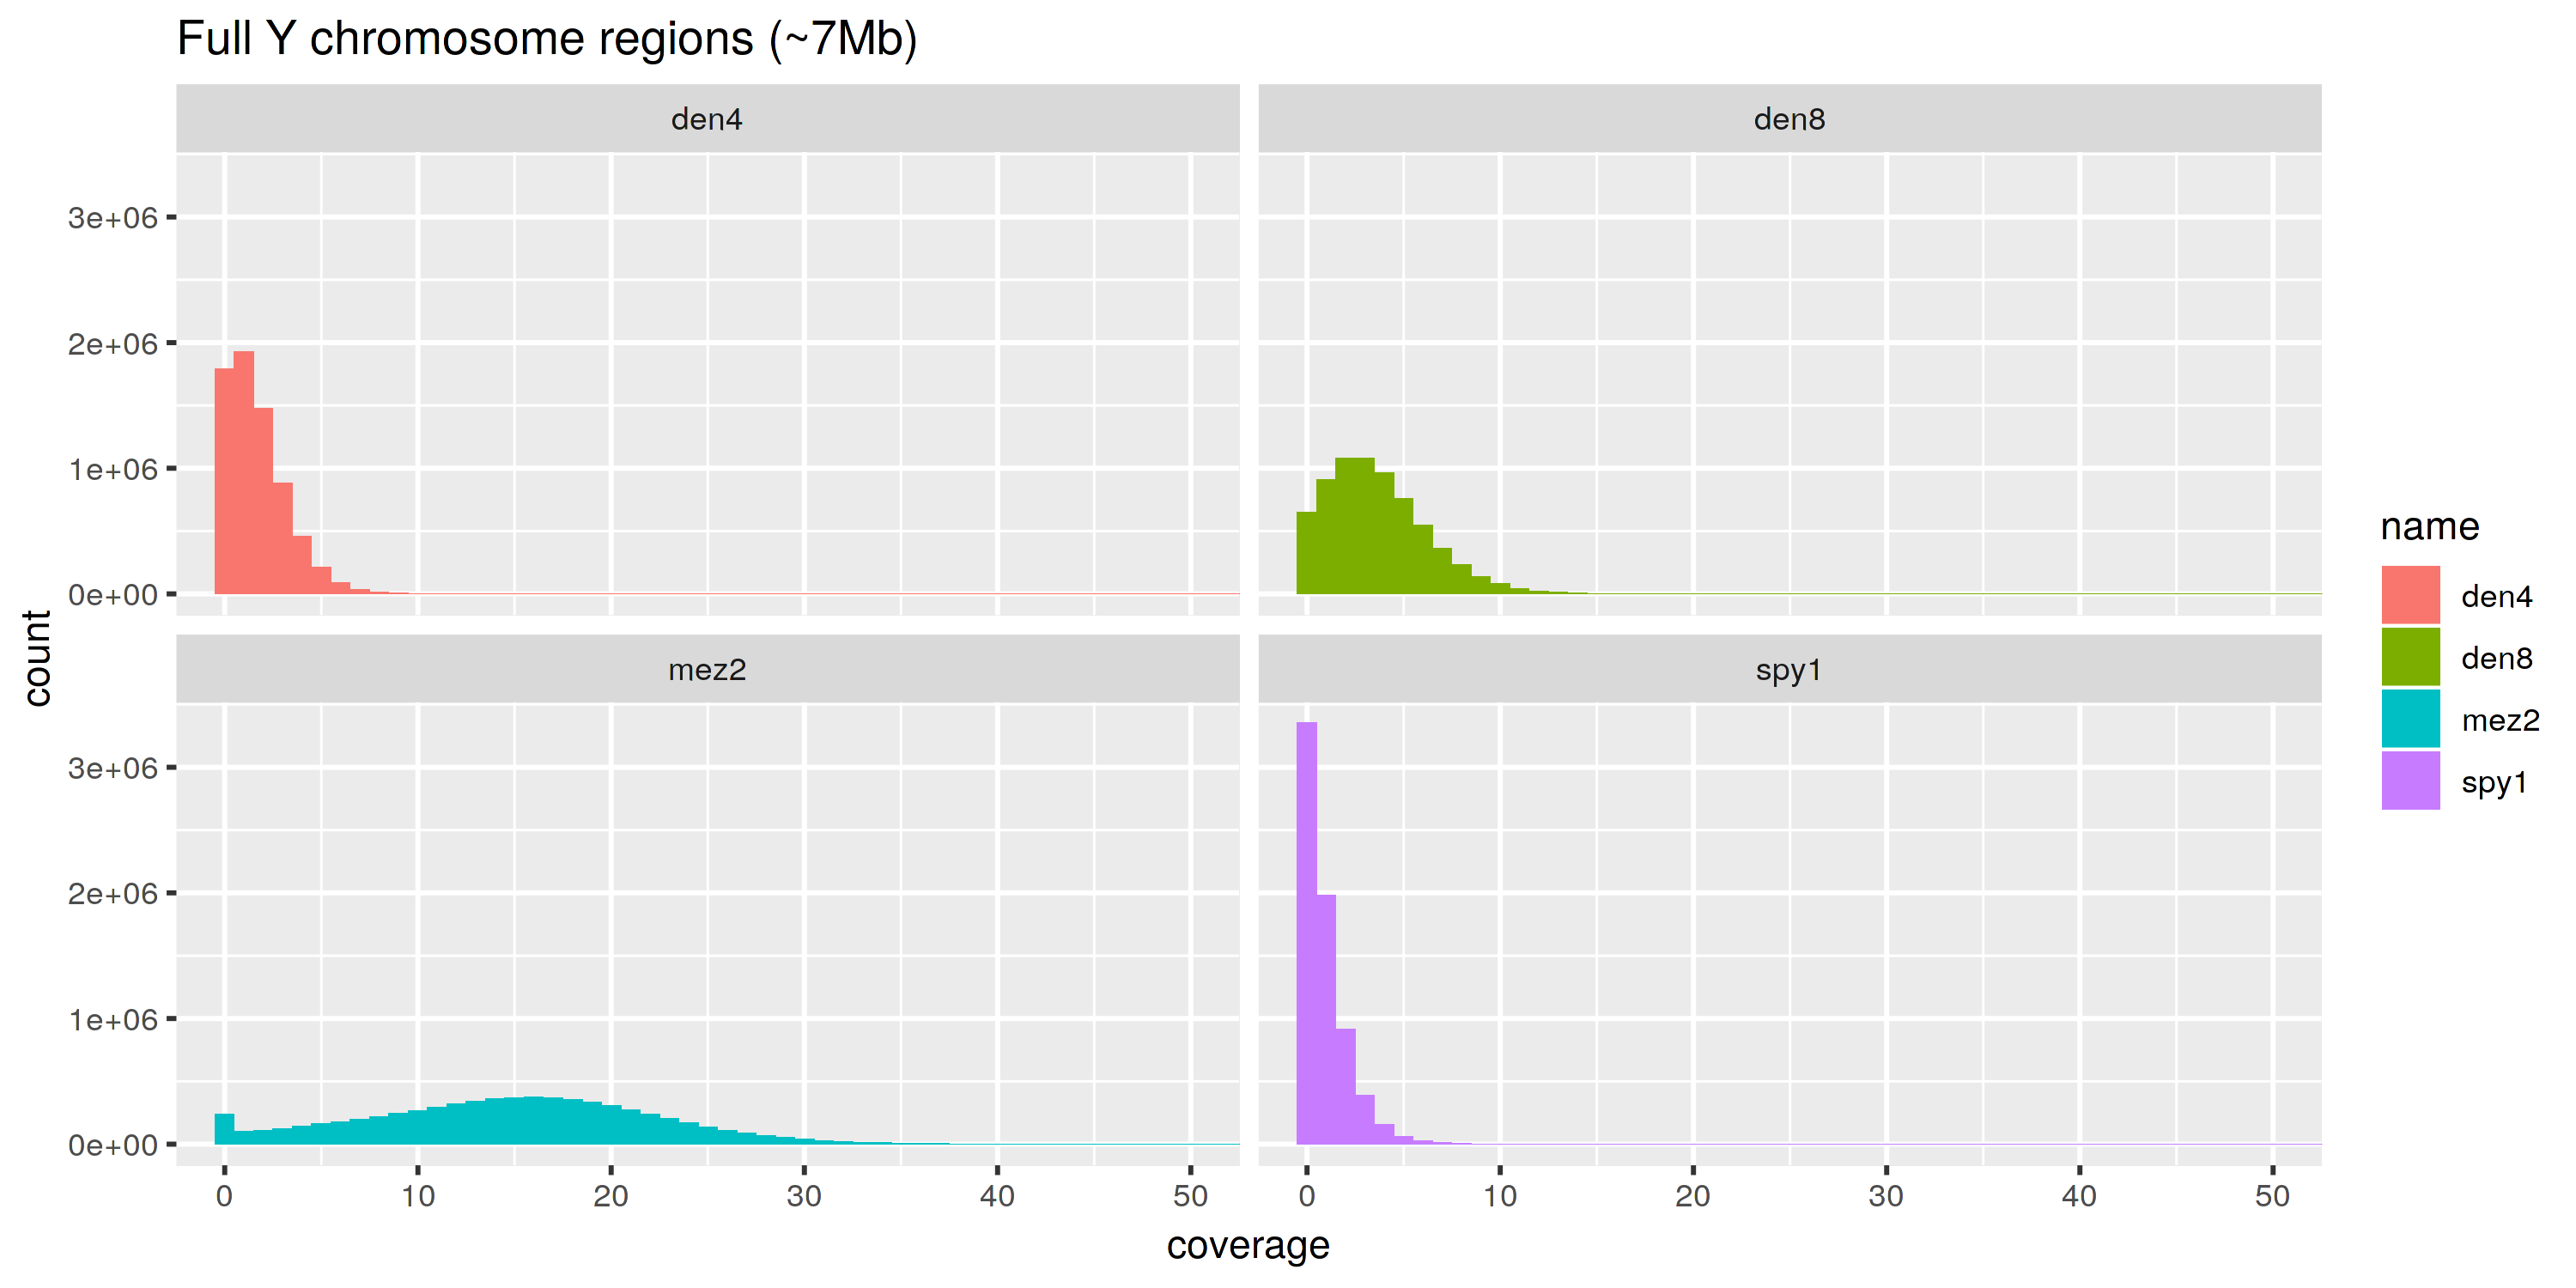

In [10]:
set_dim(10, 5, 300)

cov_df %>%
filter(regions == "full") %>%
filter(set == "capture", !name %in% c("den", "neand")) %>%
mutate(name = factor(name, levels = factors)) %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    facet_wrap(~ name) +
    coord_cartesian(x = c(0, 50)) +
    ggtitle("Full Y chromosome regions (~7Mb)")